# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 group 97 , SID1: 530369855 , SID2: 530203168, SID3: 520238484

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [1]:
import tensorflow as tf
from tensorflow import keras
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
else:
    print("TensorFlow is not using GPU")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import RandomOverSampler


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [ ]:
# Load the dataset training and test sets as numpy arrays
# assuming Data folder is present in the same directory 
# as the notebook
X_train = np.load('Data/X_train.npy')
y_train = np.load('Data/y_train.npy')
X_test = np.load('Data/X_test.npy')
y_test = np.load('Data/y_test.npy')

### Data Exploration

In [4]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)
print("Min label value:", min(np.min(y_train), np.min(y_train)))
print("Max label value:", max(np.max(y_train), np.max(y_train)))

Training set shape: (18928, 28, 28)
Test set shape: (4732, 28, 28)
Training labels shape: (18928,)
Test labels shape: (4732,)
Min label value: 0
Max label value: 10


In [5]:
nan_exists = np.isnan(X_train).any()
print("NaN exists in X_train:", nan_exists)
inf_exists = np.isinf(X_train).any()
print("Inf exists in X_train:", inf_exists)
nan_exists = np.isnan(X_test).any()
print("NaN exists in X_test:", nan_exists)
inf_exists = np.isinf(X_test).any()
print("Inf exists in X_test:", inf_exists)

NaN exists in X_train: False
Inf exists in X_train: False
NaN exists in X_test: False
Inf exists in X_test: False


Image 0 - Min: 0, Max: 255, Mean: 110.50127551020408, Std: 82.35390588611813
Image 1 - Min: 0, Max: 255, Mean: 77.81122448979592, Std: 72.76753997498355
Image 2 - Min: 0, Max: 255, Mean: 122.64413265306122, Std: 63.5298591316597
Image 3 - Min: 0, Max: 251, Mean: 118.51658163265306, Std: 95.96786627669971
Image 4 - Min: 100, Max: 255, Mean: 239.81505102040816, Std: 37.36807034929754


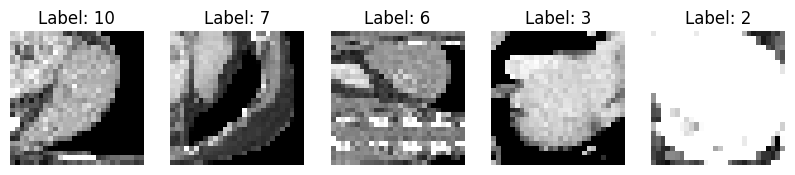

In [6]:
# Shows images, along with their labels and basic statistics about the images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    img = X_train[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
    print(f"Image {i} - Min: {img.min()}, Max: {img.max()}, Mean: {img.mean()}, Std: {img.std()}")
plt.show()

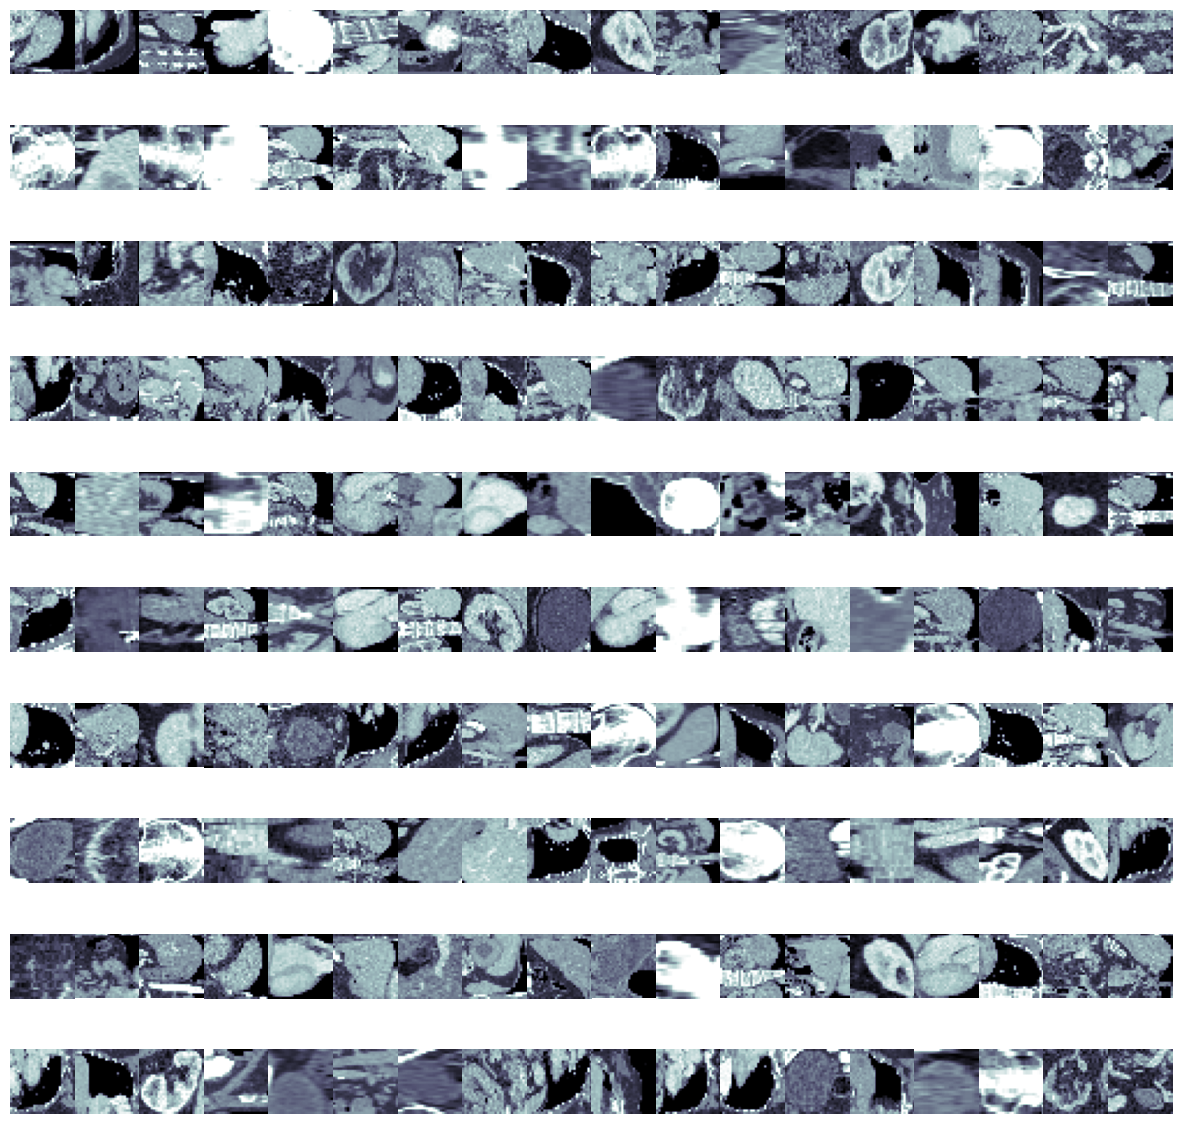

In [7]:
def plot_dataset(x):
    fig, axes = plt.subplots(10, 18, figsize=(15, 15))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(x[i], cmap=plt.cm.bone)
        ax.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

plot_dataset(X_train)

Training labels distribution: Counter({6: 4201, 10: 2196, 0: 1741, 9: 1682, 5: 1651, 4: 1562, 8: 1546, 7: 1519, 3: 978, 1: 936, 2: 916})
Test labels distribution: Counter({6: 1050, 10: 549, 0: 436, 9: 420, 5: 413, 4: 390, 8: 386, 7: 380, 3: 245, 1: 234, 2: 229})


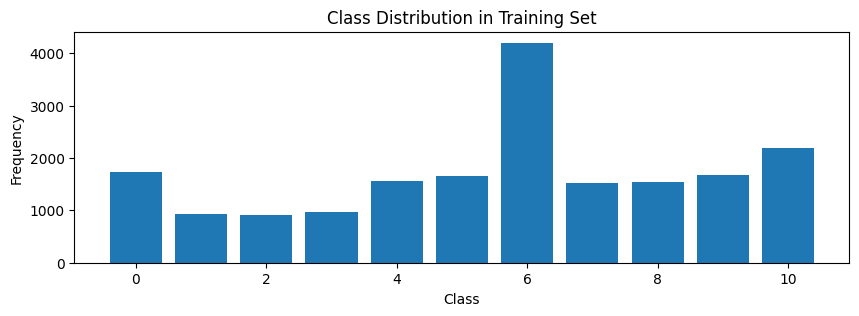

In [8]:

# Calculate the number of samples for each category
train_label_count = Counter(y_train)
test_label_count = Counter(y_test)
print("Training labels distribution:", train_label_count)
print("Test labels distribution:", test_label_count)

# Visualization category distribution
plt.subplots(figsize=(10, 3))
plt.bar(train_label_count.keys(), train_label_count.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.show()


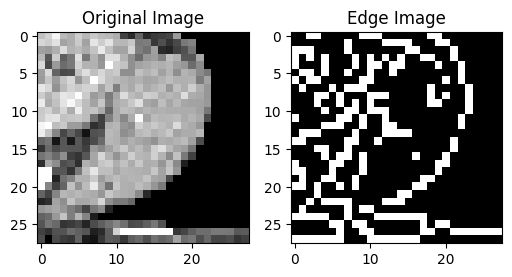

In [9]:
import cv2

# select a sample
sample_image = X_train[0]

# Applying Canny Edge Detection
edges = cv2.Canny((sample_image * 255).astype(np.uint8), 100, 200)

plt.figure(figsize=(6, 3))
plt.subplot(121), plt.imshow(sample_image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge Image')
plt.show()


In [10]:
# Calculate the average pixel intensity and standard deviation for the entire dataset
mean_intensity = np.mean(X_train)
std_intensity = np.std(X_train)

print(f"Average pixel intensity across the dataset: {mean_intensity:.2f}")
print(f"Standard deviation of pixel intensities across the dataset: {std_intensity:.2f}")


Average pixel intensity across the dataset: 124.40
Standard deviation of pixel intensities across the dataset: 71.44


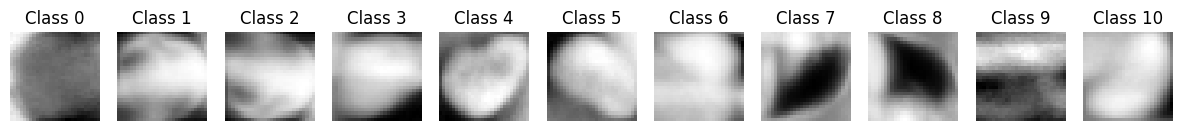

In [11]:
# Visualize the average image for each category
unique_labels = np.unique(y_train)
average_images = {}

for label in unique_labels:
    average_images[label] = np.mean(X_train[y_train == label], axis=0)

fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 2))
for label, ax in zip(unique_labels, axes):
    ax.imshow(average_images[label], cmap='gray')
    ax.set_title(f"Class {label}")
    ax.axis('off')
plt.show()


### Data Preprocessing

In [12]:
# Standardisation
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Split the data to train and valid
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, train_size=0.9)
print(f"Shape of X_train_part: {X_train_part.shape}")
print(f"Shape of y_train_part: {y_train_part.shape}")

Shape of X_train_part: (17035, 28, 28)
Shape of y_train_part: (17035,)


In [13]:
# Add an extra dimension to our data to 4d
X_train_4d = np.expand_dims(X_train, -1)
X_train_part_4d = np.expand_dims(X_train_part, -1)
X_valid_4d = np.expand_dims(X_valid, -1)
X_test_4d = np.expand_dims(X_test, -1)
print(f"New shape of X_train_4: {X_train_4d.shape}")
print(f"New shape of X_train_part_4d: {X_train_part_4d.shape}")
print(f"New shape of X_valid_4d: {X_valid_4d.shape}")
print(f"New shape of X_test_4d: {X_test_4d.shape}")

New shape of X_train_4: (18928, 28, 28, 1)
New shape of X_train_part_4d: (17035, 28, 28, 1)
New shape of X_valid_4d: (1893, 28, 28, 1)
New shape of X_test_4d: (4732, 28, 28, 1)


In [14]:
# Reduce the dimension to 1d
X_train_all_1d = X_train.reshape(-1, 28*28)
X_train_1d = X_train_part.reshape(-1, 28*28)
x_val_1d = X_valid.reshape(-1, 28*28)
X_test_1d = X_test.reshape(-1, 28*28)
print(f"New shape of X_train_all_1d: {X_train_all_1d.shape}")
print(f"New shape of X_train_1d: {X_train_1d.shape}")
print(f"New shape of x_val_1d: {x_val_1d.shape}")
print(f"New shape of X_test_1d: {X_test_1d.shape}")

New shape of X_train_all_1d: (18928, 784)
New shape of X_train_1d: (17035, 784)
New shape of x_val_1d: (1893, 784)
New shape of X_test_1d: (4732, 784)


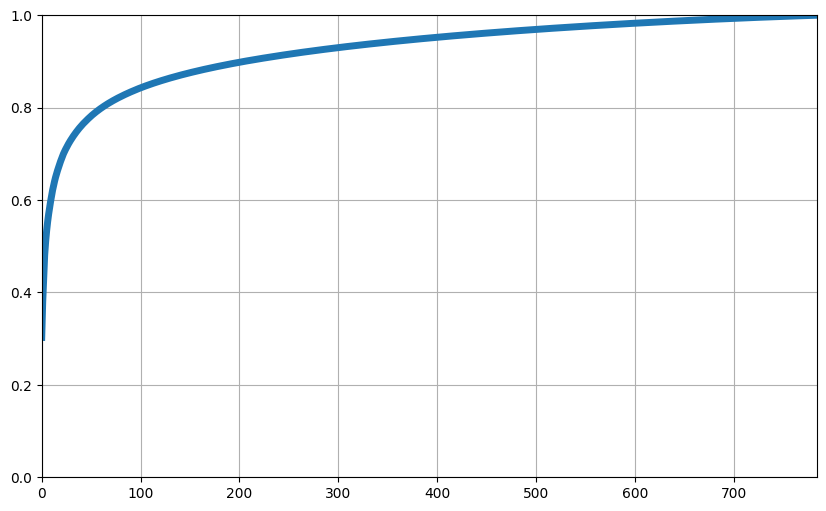

In [15]:
from sklearn.decomposition import PCA
pca = PCA()  # Create a PCA object
pca.fit(X_train_all_1d)  # Fit PCA on the dataset X_train_all_1d
cumsum = np.cumsum(pca.explained_variance_ratio_)  # Calculate the cumulative sum of explained variance ratio
# Plotting cumulative explained variance
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.plot(cumsum, linewidth=5)  # Plot the cumulative sum with a line width of 5
plt.axis([0, X_train_all_1d.shape[1], 0.0, 1])  # Set the axes limits of the plot
plt.grid(True)  # Enable grid on the plot
plt.show()  # Display the plot

In [16]:
pca = PCA(n_components=0.95)  # Initialize PCA to retain 95% of the variance
X_train_all_dec = pca.fit_transform(X_train_all_1d)
X_test_dec = pca.transform(X_test_1d)


In [17]:
pca = PCA(n_components=X_train_all_dec.shape[-1])  # Initialize PCA with components equal to number of features in X_train_all_dec
X_train_dec = pca.fit_transform(X_train_1d)  # Fit PCA and transform the training subset
x_val_dec = pca.transform(x_val_1d)  # Transform the validation dataset using the already fitted PCA

In [18]:
print(f"New shape of X_train_all_1d: {X_train_all_1d.shape}")
print(f"New shape of X_train_1d: {X_train_1d.shape}")
print(f"New shape of x_val_1d: {x_val_1d.shape}")
print(f"New shape of X_test_1d: {X_test_1d.shape}")
print(X_train_all_dec.shape)
print(X_train_dec.shape)
print(x_val_dec.shape)
print(X_test_dec.shape)

New shape of X_train_all_1d: (18928, 784)
New shape of X_train_1d: (17035, 784)
New shape of x_val_1d: (1893, 784)
New shape of X_test_1d: (4732, 784)
(18928, 389)
(17035, 389)
(1893, 389)
(4732, 389)


In [19]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_test_resampled, y_test_resampled = ros.fit_resample(X_test.reshape(X_test.shape[0], -1), y_test)
#check
unique, counts = np.unique(y_train_resampled, return_counts=True)
print("Resampled train label distribution:", dict(zip(unique, counts)))

Resampled train label distribution: {0: 4201, 1: 4201, 2: 4201, 3: 4201, 4: 4201, 5: 4201, 6: 4201, 7: 4201, 8: 4201, 9: 4201, 10: 4201}


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [20]:
def build_decision_tree(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=1):
    """
    Builds a decision tree model.
    
    Parameters:
    - criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    - max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    - min_samples_split: The minimum number of samples required to split an internal node.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.
    
    Returns:
    - A decision tree model instance.
    """
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    return model

# Initial instance of the model with default parameters
instance_decision_tree = build_decision_tree()
# Train the final model
instance_decision_tree.fit(X_train_resampled, y_train_resampled)

# Predict the test set
y_pred = instance_decision_tree.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the final model
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {dt_accuracy}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.6923076923076923
              precision    recall  f1-score   support

           0       0.56      0.70      0.62       436
           1       0.81      0.61      0.70       234
           2       0.50      0.70      0.59       229
           3       0.84      0.84      0.84       245
           4       0.48      0.43      0.45       390
           5       0.57      0.38      0.45       413
           6       0.92      0.80      0.85      1050
           7       0.93      0.89      0.91       380
           8       0.93      0.89      0.91       386
           9       0.37      0.63      0.47       420
          10       0.74      0.65      0.69       549

    accuracy                           0.69      4732
   macro avg       0.70      0.68      0.68      4732
weighted avg       0.72      0.69      0.70      4732



### Fully connected neural network

In [21]:
#Instance of MLP model with fixed hyperparameters
instance_mlp_model = Sequential([
    Dense(100, activation='relu', input_shape=(389,)), # 389 for PCA
    Dense(100, activation='relu'), 
    Dense(11, activation='softmax')
])
instance_mlp_model.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)
batch_size = 128
epochs = 20
history = instance_mlp_model.fit(X_train_dec, y_train_part, batch_size=batch_size,
                    epochs=epochs, validation_data=(x_val_dec, y_valid))
loss, accuracy = instance_mlp_model.evaluate(X_test_dec, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

Epoch 1/20
134/134 [==============================] - 2s 3ms/step - loss: 0.7506 - accuracy: 0.7571 - val_loss: 0.5068 - val_accuracy: 0.8368
Epoch 2/20
134/134 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.8707 - val_loss: 0.4654 - val_accuracy: 0.8505
Epoch 3/20
134/134 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9139 - val_loss: 0.4354 - val_accuracy: 0.8695
Epoch 4/20
134/134 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9335 - val_loss: 0.4956 - val_accuracy: 0.8627
Epoch 5/20
134/134 [==============================] - 0s 2ms/step - loss: 0.1466 - accuracy: 0.9507 - val_loss: 0.5131 - val_accuracy: 0.8727
Epoch 6/20
134/134 [==============================] - 0s 2ms/step - loss: 0.1230 - accuracy: 0.9596 - val_loss: 0.5343 - val_accuracy: 0.8811
Epoch 7/20
134/134 [==============================] - 0s 2ms/step - loss: 0.1291 - accuracy: 0.9625 - val_loss: 0.6077 - val_accuracy: 0.8669
Epoch 

In [22]:
def build_mlp(n_hidden_layers=2, n_hidden_neurons=50,activation_function="relu"):
    """
    Constructs a multi-layer perceptron (MLP) model using Keras.

    Parameters:
    - n_hidden_layers (int): Number of hidden layers in the MLP.
    - n_hidden_neurons (int): Number of neurons in each hidden layer.
    - activation_function (str): Activation function to use in the hidden layers, e.g., 'relu'.

    Returns:
    - model: A Keras model instance
    """
    model = Sequential()
    model.add(Dense(n_hidden_neurons, activation=activation_function, input_shape=(389,)))  
    
    for layer in range(n_hidden_layers-1):
        model.add(Dense(n_hidden_neurons, activation=activation_function))
    
    model.add(Dense(units=11, activation='softmax')) 
    return model

### Convolutional neural network

In [23]:
#Instance of CNN model with fixed hyperparameters
CNN_model = Sequential([
    # Specify the input shape
    keras.Input(shape=(28, 28, 1)),
    # Conv and pool block 1
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Conv and pool block 2
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten and classify using dense output layer
    Flatten(),
    Dropout(0.5),
    Dense(11, activation="softmax"),
])
# Compile model with loss, optimiser, and metrics

CNN_model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
batch_size = 128
epochs = 20
history = CNN_model.fit(X_train_part_4d, y_train_part, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid_4d, y_valid))
loss, accuracy = CNN_model.evaluate(X_test_4d, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

Epoch 1/20
134/134 [==============================] - 4s 4ms/step - loss: 1.5050 - accuracy: 0.4894 - val_loss: 0.9477 - val_accuracy: 0.7042
Epoch 2/20
134/134 [==============================] - 0s 3ms/step - loss: 0.8639 - accuracy: 0.7235 - val_loss: 0.6375 - val_accuracy: 0.8146
Epoch 3/20
134/134 [==============================] - 0s 3ms/step - loss: 0.6752 - accuracy: 0.7861 - val_loss: 0.5527 - val_accuracy: 0.8315
Epoch 4/20
134/134 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 0.8161 - val_loss: 0.4703 - val_accuracy: 0.8510
Epoch 5/20
134/134 [==============================] - 0s 3ms/step - loss: 0.5238 - accuracy: 0.8296 - val_loss: 0.4180 - val_accuracy: 0.8695
Epoch 6/20
134/134 [==============================] - 0s 3ms/step - loss: 0.4728 - accuracy: 0.8463 - val_loss: 0.4022 - val_accuracy: 0.8690
Epoch 7/20
134/134 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.8494 - val_loss: 0.4153 - val_accuracy: 0.8737
Epoch 

In [24]:
def build_cnn(kernel_size=3, padding='same', pool_size=(2, 2), activation='relu', dropout_rate=0.5):
    """
    Constructs a convolutional neural network using Keras.

    Parameters:
    - kernel_size (int): Size of the convolution kernel.
    - padding (str): 'valid' (no padding) or 'same' (padding to maintain dimension).
    - pool_size (tuple): Size of the pooling window.
    - activation (str): Activation function, such as 'relu' or 'sigmoid'.
    - dropout_rate (float): Proportion of neurons to drop out to prevent overfitting.

    Returns:
    - A compiled Keras model ready for training.
    """
    model = Sequential([
        keras.Input(shape=(28, 28, 1)),
        Conv2D(32, (kernel_size, kernel_size), padding=padding, activation=activation),
        MaxPooling2D(pool_size=pool_size),
        Conv2D(64, (kernel_size, kernel_size), padding=padding, activation=activation),
        MaxPooling2D(pool_size=pool_size),
        Flatten(),
        Dropout(dropout_rate),
        Dense(11, activation='softmax'),
    ])
    return model

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [100]:
# Define the parameter grid
dt_param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Setup the GridSearchCV
dt_grid_search = GridSearchCV(estimator=build_decision_tree(), param_grid=dt_param_grid, n_jobs=-1, cv=3, scoring='accuracy')

# Fit the grid search to the data
dt_grid_result = dt_grid_search.fit(X_train_resampled, y_train_resampled)

In [102]:
print("Best: %f using %s" % (dt_grid_result.best_score_, dt_grid_result.best_params_))
dt_test_accuracy = dt_grid_result.best_estimator_.score(X_test_resampled, y_test_resampled)
print(f"Accuracy on test data: {dt_test_accuracy:.4f}")

Best: 0.956310 using {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy on test data: 0.7274


In [103]:
dt_results = dt_grid_result.cv_results_
for key in ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score']:
    print(f"{key}: {sum(dt_results[key]) / len(dt_results[key])}")


mean_fit_time: 26.313743482033416
std_fit_time: 0.8966170949496478
mean_score_time: 0.02987437336533157
std_score_time: 0.002413987853874356
mean_test_score: 0.8578588778756611
std_test_score: 0.012750141678154515


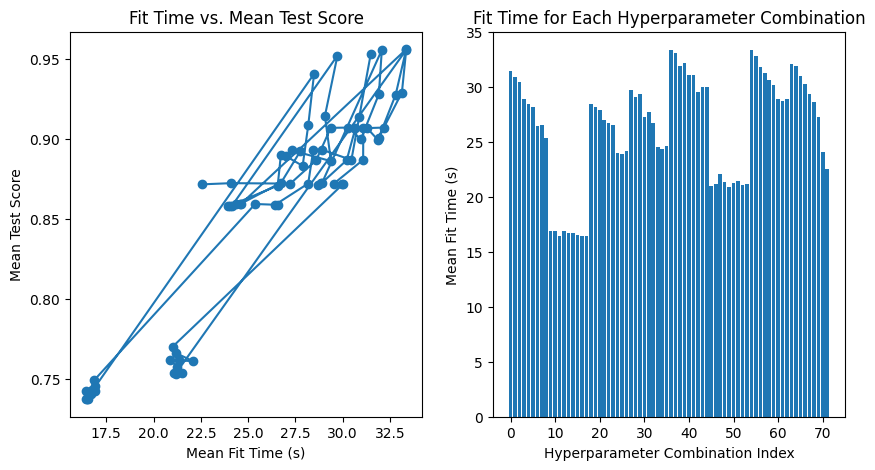

In [104]:
dt_results_df = pd.DataFrame(dt_grid_result.cv_results_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(dt_results_df['mean_fit_time'], dt_results_df['mean_test_score'], 'o-')
plt.title('Fit Time vs. Mean Test Score')
plt.xlabel('Mean Fit Time (s)')
plt.ylabel('Mean Test Score')

plt.subplot(1, 2, 2)
plt.bar(range(len(dt_results_df)), dt_results_df['mean_fit_time'])
plt.title('Fit Time for Each Hyperparameter Combination')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Fit Time (s)')
plt.show()

In [106]:
dt_results_df.to_csv("dt_grid_search_results.csv", index=False)
print(dt_results_df[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])

                                               params  mean_test_score  \
0   {'criterion': 'gini', 'max_depth': None, 'min_...         0.953129   
1   {'criterion': 'gini', 'max_depth': None, 'min_...         0.914134   
2   {'criterion': 'gini', 'max_depth': None, 'min_...         0.887062   
3   {'criterion': 'gini', 'max_depth': None, 'min_...         0.893446   
4   {'criterion': 'gini', 'max_depth': None, 'min_...         0.893446   
..                                                ...              ...   
67  {'criterion': 'entropy', 'max_depth': 30, 'min...         0.907144   
68  {'criterion': 'entropy', 'max_depth': 30, 'min...         0.886846   
69  {'criterion': 'entropy', 'max_depth': 30, 'min...         0.872282   
70  {'criterion': 'entropy', 'max_depth': 30, 'min...         0.872563   
71  {'criterion': 'entropy', 'max_depth': 30, 'min...         0.871806   

    std_test_score  mean_fit_time  
0         0.021965      31.479559  
1         0.018728      30.876014  
2  

### Fully connected neural network

In [52]:
# Tuning mlp
mlp_model = KerasClassifier(build_mlp, 
                       n_hidden_layers=2,
                       n_hidden_neurons=100,
                       activation_function="relu",
                       loss="sparse_categorical_crossentropy",
                       optimizer="sgd",
                       optimizer__learning_rate=0.01,
                       metrics=["accuracy"])

mlp_param_grid = {
    "n_hidden_layers": [2, 3, 4],
    "n_hidden_neurons": [100, 200],
    "optimizer__learning_rate": [0.1, 0.01],
    "activation_function": ["relu",'tanh']
}

mlp_grid = GridSearchCV(mlp_model, param_grid=mlp_param_grid, n_jobs=1, cv=3, verbose=2)
mlp_grid_result = mlp_grid.fit(X_train_all_dec, y_train, epochs=20, batch_size = 128) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Epoch 1/20
99/99 [==============================] - 0s 2ms/step - loss: 1.4724 - accuracy: 0.5240
Epoch 2/20
99/99 [==============================] - 0s 2ms/step - loss: 0.8525 - accuracy: 0.7369
Epoch 3/20
99/99 [==============================] - 0s 2ms/step - loss: 0.7138 - accuracy: 0.7777
Epoch 4/20
99/99 [==============================] - 0s 2ms/step - loss: 0.6446 - accuracy: 0.7997
Epoch 5/20
99/99 [==============================] - 0s 2ms/step - loss: 0.5957 - accuracy: 0.8157
Epoch 6/20
99/99 [==============================] - 0s 2ms/step - loss: 0.5554 - accuracy: 0.8284
Epoch 7/20
99/99 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.8383
Epoch 8/20
99/99 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.8482
Epoch 9/20
99/99 [==============================] - 0s 2ms/step - loss: 0.4565 - accuracy: 0.8579
Epoch 10/20
99/99 [==============================] - 0s 2

In [53]:
print("Best: %f using %s" % (mlp_grid_result.best_score_, mlp_grid_result.best_params_))
mlp_test_accuracy = mlp_grid_result.best_estimator_.score(X_test_dec, y_test)
print(f"Accuracy on test data: {mlp_test_accuracy:.4f}")

Best: 0.871619 using {'activation_function': 'relu', 'n_hidden_layers': 4, 'n_hidden_neurons': 200, 'optimizer__learning_rate': 0.1}
148/148 [==============================] - 0s 892us/step
Accuracy on test data: 0.8977


In [84]:
mlp_results = mlp_grid_result.cv_results_
for key in ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score']:
    print(f"{key}: {sum(mlp_results[key]) / len(mlp_results[key])}")


mean_fit_time: 4.210235801008013
std_fit_time: 0.034270107855616946
mean_score_time: 0.2983543972174327
std_score_time: 0.009002960949067019
mean_test_score: 0.807960919356213
std_test_score: 0.003220521148934039


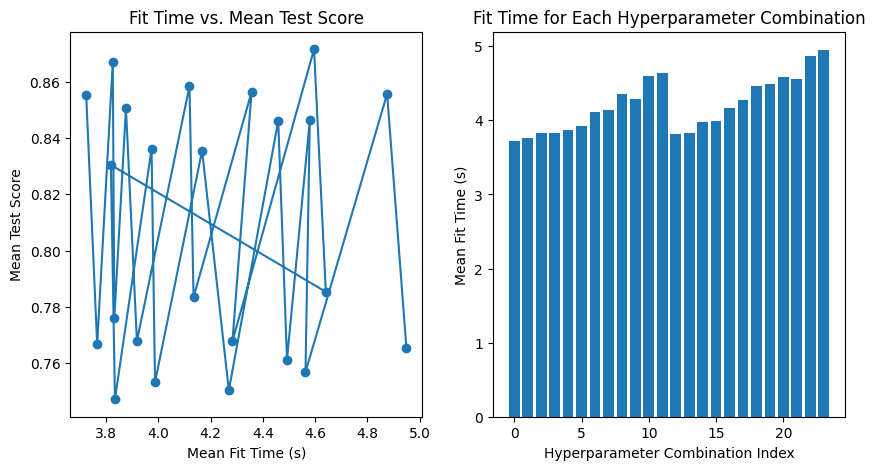

In [85]:
mlp_results_df = pd.DataFrame(mlp_grid_result.cv_results_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_results_df['mean_fit_time'], mlp_results_df['mean_test_score'], 'o-')
plt.title('Fit Time vs. Mean Test Score')
plt.xlabel('Mean Fit Time (s)')
plt.ylabel('Mean Test Score')

plt.subplot(1, 2, 2)
plt.bar(range(len(mlp_results_df)), mlp_results_df['mean_fit_time'])
plt.title('Fit Time for Each Hyperparameter Combination')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Fit Time (s)')
plt.show()

In [107]:
mlp_results_df.to_csv("mlp_grid_search_results.csv", index=False)
print(mlp_results_df[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])

                                               params  mean_test_score  \
0   {'activation_function': 'relu', 'n_hidden_laye...         0.855505   
1   {'activation_function': 'relu', 'n_hidden_laye...         0.766642   
2   {'activation_function': 'relu', 'n_hidden_laye...         0.866969   
3   {'activation_function': 'relu', 'n_hidden_laye...         0.775993   
4   {'activation_function': 'relu', 'n_hidden_laye...         0.850697   
5   {'activation_function': 'relu', 'n_hidden_laye...         0.767804   
6   {'activation_function': 'relu', 'n_hidden_laye...         0.858464   
7   {'activation_function': 'relu', 'n_hidden_laye...         0.783442   
8   {'activation_function': 'relu', 'n_hidden_laye...         0.856456   
9   {'activation_function': 'relu', 'n_hidden_laye...         0.767805   
10  {'activation_function': 'relu', 'n_hidden_laye...         0.871619   
11  {'activation_function': 'relu', 'n_hidden_laye...         0.785344   
12  {'activation_function': 'tanh', 'n

### Convolutional neural network

In [24]:
cnn_model = KerasClassifier(build_cnn, 
                            kernel_size=4,
                            padding='same',
                            pool_size=(2, 2),
                            activation="relu",
                            loss="sparse_categorical_crossentropy",
                            optimizer='adam',
                            optimizer__learning_rate=0.1,
                            metrics=["accuracy"])

cnn_param_grid = {
    'kernel_size': [3, 4],
    'padding': ['same','valid'],
    'pool_size': [(2, 2),(3,3)],
    'optimizer__learning_rate': [0.1, 0.01],
    'activation': ['relu','tanh'],
}

cnn_grid = GridSearchCV(cnn_model, param_grid=cnn_param_grid, n_jobs=1, cv=3, verbose=2)
cnn_grid_result = cnn_grid.fit(X_train_4d, y_train, epochs=20, batch_size = 128) 


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
99/99 [==============================] - 1s 3ms/step - loss: 6.8713 - accuracy: 0.1923
Epoch 2/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2984 - accuracy: 0.2220
Epoch 3/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2979 - accuracy: 0.2220
Epoch 4/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2993 - accuracy: 0.2220
Epoch 5/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2985 - accuracy: 0.2220
Epoch 6/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2976 - accuracy: 0.2220
Epoch 7/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2986 - accuracy: 0.2220
Epoch 8/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2970 - accuracy: 0.2220
Epoch 9/20
99/99 [==============================] - 0s 3ms/step - loss: 2.2994 - accuracy: 0.2220
Epoch 10/20
99/99 [==============================] - 0s 3

In [25]:
print("Best: %f using %s" % (cnn_grid_result.best_score_, cnn_grid_result.best_params_))
cnn_test_accuracy = cnn_grid_result.best_estimator_.score(X_test_4d, y_test)
print(f"Accuracy on test data: {cnn_test_accuracy:.4f}")
#Best: 0.936972 using {'activation': 'relu', 'kernel_size': 3, 'optimizer__learning_rate': 0.01, 'padding': 'same', 'pool_size': (2, 2)}

Best: 0.936972 using {'activation': 'relu', 'kernel_size': 3, 'optimizer__learning_rate': 0.01, 'padding': 'same', 'pool_size': (2, 2)}
148/148 [==============================] - 0s 1ms/step
Accuracy on test data: 0.9377


In [92]:
cnn_results = cnn_grid_result.cv_results_
for key in ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score']:
    print(f"{key}: {sum(cnn_results[key]) / len(cnn_results[key])}")

mean_fit_time: 6.202566581467787
std_fit_time: 0.05757844152048137
mean_score_time: 0.35256557414929074
std_score_time: 0.014186688728827505
mean_test_score: 0.6059080185845407
std_test_score: 0.055335034980442996


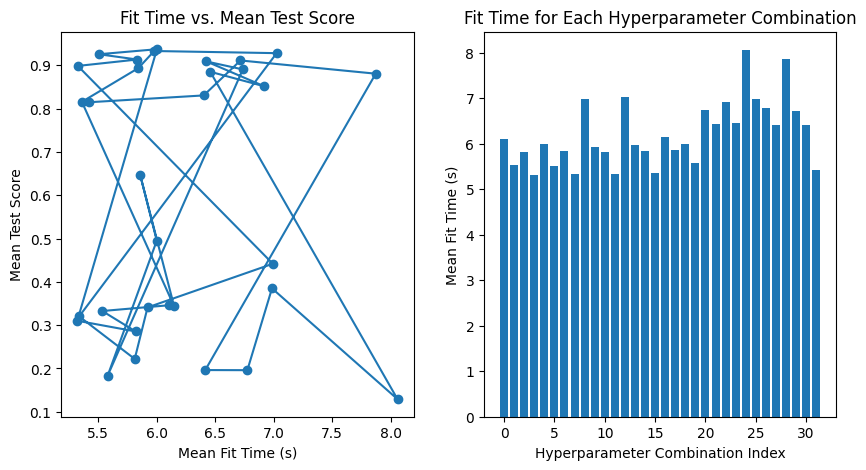

In [68]:
cnn_results_df = pd.DataFrame(cnn_grid_result.cv_results_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_results_df['mean_fit_time'], cnn_results_df['mean_test_score'], 'o-')
plt.title('Fit Time vs. Mean Test Score')
plt.xlabel('Mean Fit Time (s)')
plt.ylabel('Mean Test Score')

plt.subplot(1, 2, 2)
plt.bar(range(len(cnn_results_df)), cnn_results_df['mean_fit_time'])
plt.title('Fit Time for Each Hyperparameter Combination')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Mean Fit Time (s)')
plt.show()

In [86]:
cnn_results_df.to_csv("cnn_grid_search_results.csv", index=False)
print(cnn_results_df[['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']])

                                               params  mean_test_score  \
0   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.345896   
1   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.332582   
2   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.285496   
3   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.310113   
4   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.936972   
5   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.925401   
6   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.913197   
7   {'activation': 'relu', 'kernel_size': 3, 'opti...         0.898404   
8   {'activation': 'relu', 'kernel_size': 4, 'opti...         0.441720   
9   {'activation': 'relu', 'kernel_size': 4, 'opti...         0.340911   
10  {'activation': 'relu', 'kernel_size': 4, 'opti...         0.221946   
11  {'activation': 'relu', 'kernel_size': 4, 'opti...         0.320158   
12  {'activation': 'relu', 'kernel_siz

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

In [159]:
def evaluate_and_plot_examples(model, X_test, y_test, n_images=100, n_rows=10, n_cols=10):
    np.random.seed(42)  # Setting random seed for reproducibility
    indices = np.random.choice(len(X_test), n_images, replace=False)
    random_X_test = X_test[indices]
    random_y_test = y_test[indices]

    # Predict the selected images
    if hasattr(model, 'predict_proba'):  # Check if model has predict_proba method (e.g., sklearn classifiers)
        y_proba = model.predict_proba(random_X_test)
        y_pred = np.argmax(y_proba, axis=-1)
    else:  # For models with predict method directly giving the classes (e.g., Keras models)
        y_pred = model.predict(random_X_test)
        if len(y_pred.shape) > 1:
            y_pred = np.argmax(y_pred, axis=-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(random_y_test, y_pred)
    print(f"Model Accuracy on the selected images: {accuracy:.4f}")
    print(classification_report(random_y_test, y_pred))
    
    # Plot examples
    if random_X_test.shape[-1] == 1:
        random_X_test = random_X_test.squeeze(axis=-1)  # Remove channel dimension if grayscale
    
    plt.figure(figsize=(20, 2 * n_rows))
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(random_X_test[i], cmap='binary')
        plt.title(f"Pred: {y_pred[i]}, Actual: {random_y_test[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Algorithm of choice from first six weeks of course

In [160]:
# Build final model using the best parameters from grid search
# Best Parameters {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
best_dt_model = build_decision_tree(
    criterion='entropy', 
    max_depth=None,  # using the best parameters from hyperparameter tuning
    min_samples_split=2,
    min_samples_leaf=1
)

# Train the final model
best_dt_model.fit(X_train_resampled, y_train_resampled)

# Predict the test set
y_pred = best_dt_model.predict(X_test.reshape(X_test.shape[0], -1))

# Evaluate the final model
best_dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {best_dt_accuracy}")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.7322485207100592
              precision    recall  f1-score   support

           0       0.74      0.67      0.71       436
           1       0.64      0.68      0.66       234
           2       0.62      0.70      0.66       229
           3       0.84      0.88      0.86       245
           4       0.50      0.53      0.51       390
           5       0.55      0.56      0.56       413
           6       0.88      0.87      0.88      1050
           7       0.92      0.91      0.92       380
           8       0.91      0.93      0.92       386
           9       0.49      0.46      0.48       420
          10       0.70      0.71      0.70       549

    accuracy                           0.73      4732
   macro avg       0.71      0.72      0.71      4732
weighted avg       0.73      0.73      0.73      4732



### Fully connected neural network

In [28]:
#Best FCNN model
#Best Parameters {'activation_function': 'relu', 'n_hidden_layers': 4, 'n_hidden_neurons': 200, 'optimizer__learning_rate': 0.1}
best_mlp_model = KerasClassifier(build_mlp, 
                                n_hidden_layers=4,
                                n_hidden_neurons=200,
                                activation_function="relu",
                                loss="sparse_categorical_crossentropy",
                                optimizer="sgd",
                                optimizer__learning_rate=0.1,
                                metrics=["accuracy"],
                                epochs=20,
                                batch_size = 128,
                                verbose=2)

best_mlp_model.fit(X_train_all_dec, y_train)
best_mlp_accuracy = best_mlp_model.score(X_test_dec, y_test)
y_pred = best_mlp_model.predict(X_test_dec)

Epoch 1/20
148/148 - 0s - loss: 1.2951 - accuracy: 0.5711 - 490ms/epoch - 3ms/step
Epoch 2/20
148/148 - 0s - loss: 0.6927 - accuracy: 0.7783 - 250ms/epoch - 2ms/step
Epoch 3/20
148/148 - 0s - loss: 0.5620 - accuracy: 0.8228 - 249ms/epoch - 2ms/step
Epoch 4/20
148/148 - 0s - loss: 0.4790 - accuracy: 0.8457 - 256ms/epoch - 2ms/step
Epoch 5/20
148/148 - 0s - loss: 0.4091 - accuracy: 0.8693 - 245ms/epoch - 2ms/step
Epoch 6/20
148/148 - 0s - loss: 0.3504 - accuracy: 0.8882 - 252ms/epoch - 2ms/step
Epoch 7/20
148/148 - 0s - loss: 0.3076 - accuracy: 0.9012 - 251ms/epoch - 2ms/step
Epoch 8/20
148/148 - 0s - loss: 0.2630 - accuracy: 0.9131 - 248ms/epoch - 2ms/step
Epoch 9/20
148/148 - 0s - loss: 0.2295 - accuracy: 0.9246 - 254ms/epoch - 2ms/step
Epoch 10/20
148/148 - 0s - loss: 0.2031 - accuracy: 0.9333 - 249ms/epoch - 2ms/step
Epoch 11/20
148/148 - 0s - loss: 0.1701 - accuracy: 0.9453 - 251ms/epoch - 2ms/step
Epoch 12/20
148/148 - 0s - loss: 0.1453 - accuracy: 0.9539 - 250ms/epoch - 2ms/step
E

### Convolutional neural network

In [29]:
print("Test accuracy:", best_mlp_accuracy)
print(classification_report(y_test, y_pred))

Test accuracy: 0.8951817413355875
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       436
           1       0.81      0.81      0.81       234
           2       0.82      0.82      0.82       229
           3       0.95      0.96      0.95       245
           4       0.80      0.75      0.78       390
           5       0.84      0.73      0.78       413
           6       0.96      0.97      0.97      1050
           7       0.98      0.98      0.98       380
           8       0.97      0.99      0.98       386
           9       0.82      0.89      0.85       420
          10       0.89      0.90      0.90       549

    accuracy                           0.90      4732
   macro avg       0.88      0.88      0.88      4732
weighted avg       0.89      0.90      0.89      4732



In [25]:
#Best CNN model
#Best Parameters {'activation': 'relu', 'kernel_size': 3, 'optimizer__learning_rate': 0.01, 'padding': 'same', 'pool_size': (2, 2)}
best_cnn_model = KerasClassifier(build_cnn, 
                                kernel_size=3,
                                padding='same',
                                pool_size=(2, 2),
                                activation="relu",
                                loss="sparse_categorical_crossentropy",
                                optimizer='adam',
                                optimizer__learning_rate=0.01,
                                metrics=["accuracy"],
                                epochs=20,
                                batch_size = 128,
                                verbose=2)

best_cnn_model.fit(X_train_4d, y_train)
best_cnn_accuracy = best_cnn_model.score(X_test_4d, y_test)
y_pred = best_cnn_model.predict(X_test_4d)

Epoch 1/20
148/148 - 1s - loss: 0.8393 - accuracy: 0.7244 - 732ms/epoch - 5ms/step
Epoch 2/20
148/148 - 0s - loss: 0.3856 - accuracy: 0.8739 - 340ms/epoch - 2ms/step
Epoch 3/20
148/148 - 0s - loss: 0.3031 - accuracy: 0.8994 - 337ms/epoch - 2ms/step
Epoch 4/20
148/148 - 0s - loss: 0.2622 - accuracy: 0.9105 - 343ms/epoch - 2ms/step
Epoch 5/20
148/148 - 0s - loss: 0.2363 - accuracy: 0.9193 - 341ms/epoch - 2ms/step
Epoch 6/20
148/148 - 0s - loss: 0.2354 - accuracy: 0.9202 - 340ms/epoch - 2ms/step
Epoch 7/20
148/148 - 0s - loss: 0.2212 - accuracy: 0.9242 - 345ms/epoch - 2ms/step
Epoch 8/20
148/148 - 0s - loss: 0.2102 - accuracy: 0.9258 - 356ms/epoch - 2ms/step
Epoch 9/20
148/148 - 0s - loss: 0.1950 - accuracy: 0.9314 - 347ms/epoch - 2ms/step
Epoch 10/20
148/148 - 0s - loss: 0.1995 - accuracy: 0.9305 - 345ms/epoch - 2ms/step
Epoch 11/20
148/148 - 0s - loss: 0.1942 - accuracy: 0.9332 - 343ms/epoch - 2ms/step
Epoch 12/20
148/148 - 0s - loss: 0.1830 - accuracy: 0.9386 - 337ms/epoch - 2ms/step
E

In [26]:
print("Test accuracy:", best_cnn_accuracy)
print(classification_report(y_test, y_pred))

Test accuracy: 0.9410397295012679
37/37 - 0s - 45ms/epoch - 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       436
           1       0.82      0.92      0.87       234
           2       0.93      0.88      0.90       229
           3       0.98      0.99      0.99       245
           4       0.80      0.89      0.84       390
           5       0.89      0.82      0.86       413
           6       0.99      0.99      0.99      1050
           7       0.99      0.99      0.99       380
           8       0.98      1.00      0.99       386
           9       0.93      0.96      0.94       420
          10       0.98      0.92      0.95       549

    accuracy                           0.94      4732
   macro avg       0.93      0.93      0.93      4732
weighted avg       0.94      0.94      0.94      4732

